In [1]:
import osmnx as ox
import networkx as nx
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import gpxpy
import gpxpy.gpx
import os

In [2]:
# Étape 1 : Télécharger les données avec un filtre personnalisé pour les types de rues
ville = "Paris, France"

#filtre qui fonctionne pas mal du tout:
custom_filter = ('["highway"~"residential|primary|secondary|tertiary|unclassified|pedestrian|tertiary_link|living_street|steps|secondary_link|primary_link|road|busway"]')

#custom_filter = ('["highway"~"residential|primary|secondary|tertiary|service|unclassified|pedestrian|footway|tertiary_link|living_street|steps|secondary_link|primary_link|track|path|bridleway|road|busway|corridor|elevator"]')
G = ox.graph_from_place(ville, network_type='walk', custom_filter=custom_filter)

In [3]:
# Étape 4 : Vérifier si toutes les arêtes ont les attributs 'length' et 'geometry' et le calculer si nécessaire
G_init = G.copy()
for u, v, key, data in G_init.edges(keys=True, data=True):
    if 'length' not in data:
        print("il manque la longueur pour l'arête", u, v, key)    
    if 'geometry' not in data:
        x_u, y_u = G.nodes[u]['x'], G.nodes[u]['y']
        x_v, y_v = G.nodes[v]['x'], G.nodes[v]['y']
        data['geometry'] = LineString([(x_u, y_u), (x_v, y_v)])
        G.remove_edge(u, v, key=key)
        G.add_edge(u, v, key=key, **data)
        

In [4]:
# Compter le nombre de voies dans chaque catégorie et afficher leurs distances respectives dans l'ordre décroissant en km
edge_count = {} # dictionnaire pour compter le nombre de voies dans chaque catégorie
edge_length = {} # dictionnaire pour stocker la longueur totale des voies dans chaque catégorie

for u, v, key, data in G.edges(keys=True, data=True):
    highway_type = tuple(data['highway']) if isinstance(data['highway'], list) else data['highway']
    edge_count[highway_type] = edge_count.get(highway_type, 0) + 1
    edge_length[highway_type] = edge_length.get(highway_type, 0) + data['length']

# Afficher les résultats
print("\nLongueur totale des voies dans chaque catégorie :")
for key, value in sorted(edge_length.items(), key=lambda x: x[1], reverse=True):
    print(f"{key} : {value/1000:.2f} km")


Longueur totale des voies dans chaque catégorie :
residential : 1471.69 km
primary : 454.25 km
tertiary : 318.88 km
pedestrian : 311.44 km
secondary : 293.99 km
living_street : 106.45 km
unclassified : 79.34 km
primary_link : 14.99 km
('pedestrian', 'residential') : 13.85 km
('living_street', 'residential') : 12.33 km
('steps', 'pedestrian') : 9.88 km
('residential', 'unclassified') : 6.58 km
steps : 5.06 km
('residential', 'primary_link') : 3.21 km
('steps', 'residential') : 3.11 km
secondary_link : 2.71 km
('living_street', 'pedestrian') : 1.67 km
('primary', 'secondary') : 1.62 km
tertiary_link : 1.18 km
('pedestrian', 'unclassified') : 1.02 km
('primary', 'primary_link') : 0.75 km
('primary', 'tertiary') : 0.64 km
busway : 0.62 km
('secondary', 'secondary_link') : 0.61 km
('living_street', 'pedestrian', 'residential') : 0.54 km
('living_street', 'tertiary') : 0.46 km
('steps', 'pedestrian', 'residential') : 0.33 km
('steps', 'living_street') : 0.29 km
('tertiary', 'tertiary_link')

In [5]:
# Vérifier le type du graphe initial

print(f"Type de G : {type(G)}")

# Étape 2 : Convertir le graphe en un MultiGraph non orienté
G_multigraph = G.to_undirected()
G_multigraph = nx.MultiGraph(G_multigraph)

# Vérifier le type et la direction du graphe non orienté
print(f"Type de G_multigraph : {type(G_multigraph)}")
print(f"Le graphe G_multigraph est dirigé ? {G_multigraph.is_directed()}")

# Étape 3 : Reprojeter le graphe en EPSG:2154 (France)
# G_proj = ox.project_graph(G_multigraph, to_crs='EPSG:2154')
G_proj = G_multigraph.copy()

Type de G : <class 'networkx.classes.multidigraph.MultiDiGraph'>
Type de G_multigraph : <class 'networkx.classes.multigraph.MultiGraph'>
Le graphe G_multigraph est dirigé ? False


In [6]:
# Supprimer les segments qui n'on pas de name
length = 0

edges_to_remove = []
for u, v, key, data in G_proj.edges(keys=True, data=True):
    if 'name' not in data :
        edges_to_remove.append((u, v, key))
        length += data['length']

# Supprimer les arêtes identifiées
for edge in edges_to_remove:
    G_proj.remove_edge(*edge)

print(f"Nombre d'arêtes supprimées : {len(edges_to_remove)}")
print(f"Longueur totale des arêtes supprimées : {length/1000:.2f} km")


Nombre d'arêtes supprimées : 1267
Longueur totale des arêtes supprimées : 39.14 km


In [7]:
# Supprimer les segments correspondant à certaines routes spécifiques
routes_a_supprimer = ["Quai de Bercy", "Quai de la Rapée", "Place de la Porte de Pantin", "Avenue de la Porte de Pantin", "Tunnel Vers Porte de la vilette", "Tunnel Chaumont Pantin", "Rue Robert-Etlin", "Port de Bercy", "Rue du Général de Langle de Cary"]
length = 0

edges_to_remove = []
for u, v, key, data in G_proj.edges(keys=True, data=True):
    if 'name' in data:
        # Si 'name' est une liste, vérifier si un des noms est dans routes_a_supprimer
        if isinstance(data['name'], list):
            if any(route in data['name'] for route in routes_a_supprimer):
                edges_to_remove.append((u, v, key))
                length += data['length']
        # Si 'name' est une chaîne, vérifier directement
        elif data['name'] in routes_a_supprimer:
            edges_to_remove.append((u, v, key))
            length += data['length']

# Supprimer les arêtes identifiées
for edge in edges_to_remove:
    G_proj.remove_edge(*edge)

print(f"Nombre d'arêtes supprimées : {len(edges_to_remove)}")
print(f"Longueur totale des arêtes supprimées : {length/1000:.2f} km")

Nombre d'arêtes supprimées : 92
Longueur totale des arêtes supprimées : 12.48 km


In [8]:
for u, v, key, data in G_proj.edges(keys=True, data=True):
    if "Rue du Général de Langle" in data['name']:
        print(data['name'])

In [9]:
from shapely.geometry import Point as ShapelyPoint

# trouver l'arrrête qui passe par le point suivant
Point = (2.396812, 48.889350)

nearest_node = ox.distance.nearest_nodes(G_proj, X=Point[0], Y=Point[1])
print(f"Nœud le plus proche du point {Point} : {nearest_node}")
# Convertir le point en un objet Shapely Point
shapely_point = ShapelyPoint(Point)

# Trouver l'arête qui passe par le point
edges_near_point = []

for u, v, key, data in G_proj.edges(keys=True, data=True):
    if 'geometry' in data:
        geom = data['geometry']
        if geom.distance(shapely_point) < 0.0001:  # Ajuster la tolérance si nécessaire
            edges_near_point.append((u, v, key, data))
if edges_near_point:
    print(f"Arêtes proches du point {Point} :")
    for u, v, key, data in edges_near_point:
        print(f"Arête : {u} - {v}, clé : {key}, données : {data}")
else:
    print(f"Aucune arête trouvée près du point {Point}")

Nœud le plus proche du point (2.396812, 48.88935) : 130050682


Aucune arête trouvée près du point (2.396812, 48.88935)


In [10]:
# Étape 5 : Vérifier les composantes connexes du graphe
if not nx.is_connected(G_proj.to_undirected()):
    components = list(nx.connected_components(G_proj.to_undirected()))
    print(f"Le graphe n'est pas connexe. Nombre de composantes : {len(components)}")
    # On fait un graphe avec la longueur de chaques composantes
    for i, component in enumerate(components, 1):
        subgraph = G_proj.subgraph(component).copy()
        total_length = sum(data['length'] for u, v, key, data in subgraph.edges(keys=True, data=True))
        print(f"Composante {i} : {len(component)} nœuds, {subgraph.number_of_edges()} arêtes, longueur totale : {total_length:.2f} m")
    # Prendre la plus grande composante connexe
    largest_component = max(components, key=len)
    G_proj = G_proj.subgraph(largest_component).copy()
else:
    print("Le graphe est connexe.")

# Étape 6 : Simplifier le graphe en conservant les arêtes les plus courtes entre les nœuds
G_simple = nx.MultiGraph()
G_simple.add_nodes_from((n, G_proj.nodes[n]) for n in G_proj.nodes())

# Ajouter les arêtes en conservant la plus courte en cas d'arêtes multiples
for u, v, key, data in G_proj.edges(keys=True, data=True):
    if G_simple.has_edge(u, v):
        existing_edges = G_simple.get_edge_data(u, v)
        # Trouver la clé de l'arête existante avec la longueur minimale
        min_key = min(existing_edges, key=lambda k: existing_edges[k]['length'])
        if data['length'] < existing_edges[min_key]['length']:
            # Supprimer l'arête existante et ajouter la nouvelle plus courte
            G_simple.remove_edge(u, v, key=min_key)
            G_simple.add_edge(u, v, key=key, **data)
    else:
        G_simple.add_edge(u, v, key=key, **data)



Le graphe n'est pas connexe. Nombre de composantes : 498
Composante 1 : 11639 nœuds, 17938 arêtes, longueur totale : 1506512.72 m
Composante 2 : 3 nœuds, 2 arêtes, longueur totale : 166.81 m
Composante 3 : 1 nœuds, 0 arêtes, longueur totale : 0.00 m
Composante 4 : 1 nœuds, 0 arêtes, longueur totale : 0.00 m
Composante 5 : 3 nœuds, 2 arêtes, longueur totale : 158.51 m
Composante 6 : 18 nœuds, 20 arêtes, longueur totale : 2235.17 m
Composante 7 : 1 nœuds, 0 arêtes, longueur totale : 0.00 m
Composante 8 : 1 nœuds, 0 arêtes, longueur totale : 0.00 m
Composante 9 : 2 nœuds, 1 arêtes, longueur totale : 26.92 m
Composante 10 : 1 nœuds, 0 arêtes, longueur totale : 0.00 m
Composante 11 : 1 nœuds, 0 arêtes, longueur totale : 0.00 m
Composante 12 : 1 nœuds, 0 arêtes, longueur totale : 0.00 m
Composante 13 : 1 nœuds, 0 arêtes, longueur totale : 0.00 m
Composante 14 : 2 nœuds, 1 arêtes, longueur totale : 339.38 m
Composante 15 : 1 nœuds, 0 arêtes, longueur totale : 0.00 m
Composante 16 : 1 nœuds, 0

Nombre de nœuds de degré impair dans le graphe simplifié : 8212


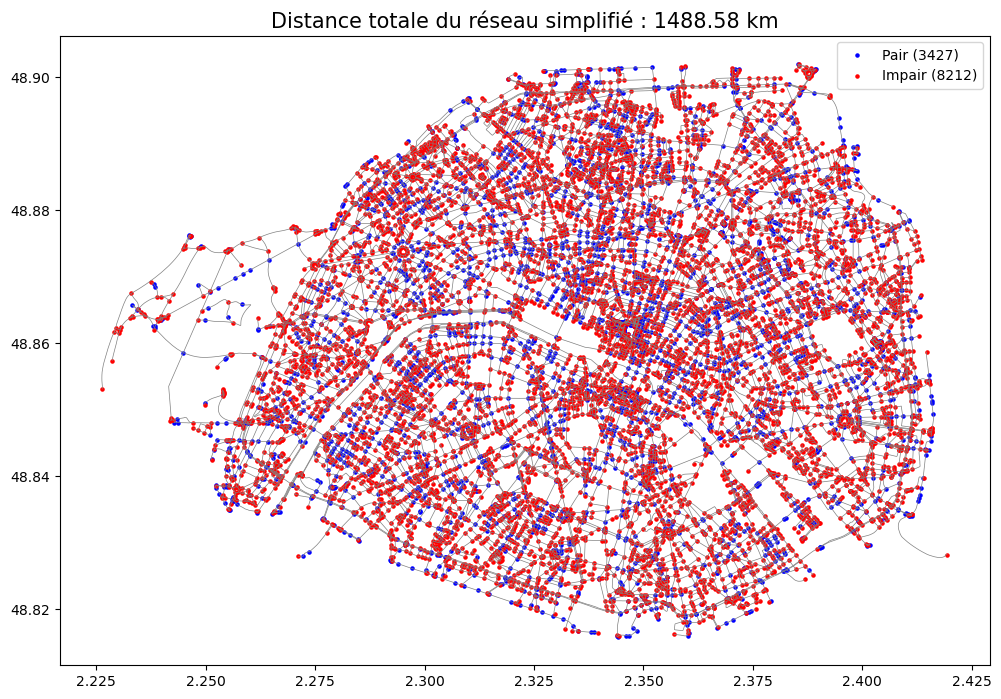

In [11]:
# Copier les attributs du graphe, y compris 'crs'
G_simple.graph.update(G_proj.graph)

# Étape 7 : Calculer la distance totale du réseau simplifié
edges_simple = ox.graph_to_gdfs(G_simple, nodes=False, edges=True)
total_length_km_simple = edges_simple['length'].sum() / 1000  # Convertir en kilomètres

# Étape 8 : Identifier les nœuds de degré impair et pair dans le graphe simplifié
degree_dict_simple = dict(G_simple.degree())
odd_degree_nodes_simple = [n for n, deg in degree_dict_simple.items() if deg % 2 == 1]
even_degree_nodes_simple = [n for n, deg in degree_dict_simple.items() if deg % 2 == 0]
print(f"Nombre de nœuds de degré impair dans le graphe simplifié : {len(odd_degree_nodes_simple)}")

# Étape 9 : Afficher le graphe simplifié avec les nœuds pairs et impairs
nodes_simple, edges_simple = ox.graph_to_gdfs(G_simple, nodes=True, edges=True)
fig, ax = plt.subplots(figsize=(12, 12))
edges_simple.plot(ax=ax, linewidth=0.5, edgecolor='gray')
nodes_simple.loc[even_degree_nodes_simple].plot(
    ax=ax, color='blue', markersize=5, label=f'Pair ({len(even_degree_nodes_simple)})'
)
nodes_simple.loc[odd_degree_nodes_simple].plot(
    ax=ax, color='red', markersize=5, label=f'Impair ({len(odd_degree_nodes_simple)})'
)
ax.set_title(f"Distance totale du réseau simplifié : {total_length_km_simple:.2f} km", fontsize=15)
ax.legend()
plt.show()


In [12]:
# Étape 10 : Calculer les distances aux nœuds impairs les plus proches avec une profondeur maximale de 6 niveaux et un maximum de 10 connexions par nœud
pairwise_distances = {}
max_depth = 6
max_connections = 10

for u in odd_degree_nodes_simple:
    visited = set()
    queue = [(u, 0)]  # (current_node, current_distance)
    local_distances = {}
    
    while queue:
        current_node, current_distance = queue.pop(0)
        if current_node in visited:
            continue
        visited.add(current_node)

        # Si le nœud est impair et différent de u, ajouter la distance
        if current_node in odd_degree_nodes_simple and current_node != u:
            local_distances[current_node] = current_distance
        
        # Si la distance est inférieure à max_depth et le nombre de connexions est inférieur à max_connections, ajouter les voisins à la queue
        if current_distance < max_depth and len(local_distances) < max_connections:
            for neighbor in G_simple.neighbors(current_node):
                if neighbor not in visited:
                    queue.append((neighbor, current_distance + 1))
    
    # Ajouter les distances trouvées à pairwise_distances
    for v, distance in local_distances.items():
        pairwise_distances[(u, v)] = distance

In [13]:
# Étape 11 : Construire le graphe complet pondéré avec les distances les plus proches
G_odd_complete = nx.Graph()
for (u, v), distance in pairwise_distances.items():
    G_odd_complete.add_edge(u, v, weight=distance)


In [14]:

# Étape 12 : Trouver l'appariement parfait de poids minimal
# Pour NetworkX 3.x, la fonction min_weight_matching n'accepte plus les paramètres 'maximize' ou 'maxcardinality'
min_weight_matching = nx.algorithms.matching.min_weight_matching(
    G_odd_complete, weight='weight'
)

In [15]:

# Étape 13 : Ajouter les arêtes correspondantes au graphe simplifié pour le rendre eulérien
# Copier le graphe simplifié pour créer le graphe augmenté
augmented_G = G_simple.copy()

# Initialiser une clé unique pour les nouvelles arêtes
unique_edge_key = max([key for _, _, key in augmented_G.edges(keys=True)], default=0) + 1

# Pour chaque paire de nœuds appariés
for u, v in min_weight_matching:
    # Trouver le chemin le plus court entre les nœuds appariés
    shortest_path = nx.shortest_path(G_simple, source=u, target=v, weight='length')
    path_edges = list(zip(shortest_path[:-1], shortest_path[1:]))
    # Ajouter chaque arête du chemin le plus court au graphe augmenté
    for edge_u, edge_v in path_edges:
        # Récupérer les données de l'arête depuis G_simple
        edge_data = G_simple.get_edge_data(edge_u, edge_v)
        
        # Puisque G_simple est simplifié, il y a une seule arête entre edge_u et edge_v
        # Ajouter l'arête avec une nouvelle clé unique
        for key, data in edge_data.items():
            augmented_G.add_edge(edge_u, edge_v, key=unique_edge_key, **data)
            unique_edge_key += 1

In [16]:

# Étape 14 : Vérifier si le graphe est maintenant eulérien
if nx.is_eulerian(augmented_G):
    print("Le graphe est maintenant eulérien.")
else:
    print("Le graphe n'est toujours pas eulérien.")

# Étape 15 : Mettre à jour les GeoDataFrames
nodes_aug, edges_aug = ox.graph_to_gdfs(augmented_G, nodes=True, edges=True)
total_length_km_aug = edges_aug['length'].sum() / 1000  # Convertir en kilomètres

# affiche la distance totale du réseau augmenté
print(f"Distance totale du réseau augmenté : {total_length_km_aug:.2f} km")


Le graphe est maintenant eulérien.
Distance totale du réseau augmenté : 1888.34 km


In [17]:
# Coordonnées GPS de la cathédrale Notre-Dame de Paris
notre_dame_coords = (48.853318, 2.348939)

# Trouver le nœud le plus proche dans le graphe
start_node = ox.distance.nearest_nodes(augmented_G, X=notre_dame_coords[1], Y=notre_dame_coords[0])
print(f"Nœud le plus proche de la cathédrale Notre-Dame : {start_node}")

Nœud le plus proche de la cathédrale Notre-Dame : 2134912116


In [18]:
def improved_multigraph_eulerian_circuit(G, source):
    """
    Génère un circuit eulérien pour un MultiGraph tout en minimisant les demi-tours futurs.
    Retourne un générateur de triplets (u, v, key).
    """
    if G.is_directed():
        degree = G.out_degree
        edges = G.out_edges
    else:
        degree = G.degree
        edges = G.edges

    vertex_stack = [(source, None)]  # Pile pour suivre les nœuds visités
    last_vertex = None
    last_key = None
    visited_edges = set()  # Pour suivre les arêtes déjà visitées

    while vertex_stack:
        current_vertex, current_key = vertex_stack[-1]

        # Si le nœud actuel n'a plus d'arêtes disponibles
        if degree(current_vertex) == 0:
            if last_vertex is not None:
                yield (last_vertex, current_vertex, last_key)
            last_vertex, last_key = current_vertex, current_key
            vertex_stack.pop()
        else:
            # Récupérer toutes les arêtes disponibles
            available_edges = [
                triple for triple in edges(current_vertex, keys=True)
                if triple not in visited_edges
            ]

            # Prioriser les arêtes en fonction des conséquences futures
            def edge_priority(triple):
                _, next_vertex, _ = triple
                # Compter les arêtes restantes du nœud cible
                remaining_edges = [
                    e for e in edges(next_vertex, keys=True)
                    if e not in visited_edges
                ]
                print(len(remaining_edges))
                return len(remaining_edges)
            
            # Trier les arêtes par priorité (plus d'options futures en premier)
            available_edges.sort(key=edge_priority, reverse=True)
            
            # Choisir la meilleure arête disponible
            next_edge = None
            for u, v, key in available_edges:
                # Éviter les demi-tours immédiats si possible
                if len(vertex_stack) > 1 and v == vertex_stack[-2][0]:
                    continue
                next_edge = (u, v, key)
                break

            # Si toutes les arêtes causent un demi-tour, en choisir une arbitrairement
            if next_edge is None:
                next_edge = available_edges[0]

            # Ajouter l'arête choisie au circuit
            u, v, key = next_edge
            vertex_stack.append((v, key))
            visited_edges.add((u, v, key))
            G.remove_edge(u, v, key)

In [19]:
def strategic_multigraph_eulerian_circuit(G, source):
    """
    Génère un circuit eulérien pour un MultiGraph en minimisant les demi-tours futurs
    en priorisant les nœuds voisins ayant plusieurs arêtes avec le nœud actuel.
    Retourne un générateur de triplets (u, v, key).
    """
    if G.is_directed():
        edges = G.out_edges
    else:
        edges = G.edges

    vertex_stack = [(source, None)]  # Pile pour suivre les nœuds visités
    last_vertex = None
    last_key = None
    visited_edges = set()  # Pour suivre les arêtes déjà visitées

    while vertex_stack:
        current_vertex, current_key = vertex_stack[-1]

        # Si le nœud actuel n'a plus d'arêtes disponibles
        if G.degree(current_vertex) == 0:
            if last_vertex is not None:
                yield (last_vertex, current_vertex, last_key)
            last_vertex, last_key = current_vertex, current_key
            vertex_stack.pop()
        else:
            # Récupérer toutes les arêtes disponibles
            available_edges = [
                triple for triple in edges(current_vertex, keys=True)
                if triple not in visited_edges
            ]

            # Prioriser les arêtes en fonction du nombre d'arêtes avec le nœud voisin
            def edge_priority(triple):
                _, next_vertex, _ = triple
                # Compter combien d'arêtes relient le nœud actuel au nœud voisin
                connection = sum(
                    1 for e in edges(current_vertex, keys=True)
                    if e[1] == next_vertex and e not in visited_edges
                )
                print(connection)
                return connection
                
            print(available_edges)
            # Trier les arêtes par priorité (plus d'arêtes avec le nœud voisin en premier)
            available_edges.sort(key=edge_priority, reverse=True)
            print(available_edges)
            # Choisir la meilleure arête disponible
            next_edge = available_edges[0]

            # Ajouter l'arête choisie au circuit
            u, v, key = next_edge
            vertex_stack.append((v, key))
            visited_edges.add((u, v, key))
            G.remove_edge(u, v, key)

In [20]:
# Étape 17 : Trouver le circuit eulérien
# euler_circuit = list(nx.eulerian_circuit(augmented_G, source=start_node, keys=True))
Custom_G = augmented_G.copy()
euler_circuit = list(strategic_multigraph_eulerian_circuit(Custom_G, source=start_node))

# Initialiser la distance totale du circuit eulérien
total_eulerian_length = 0

# Calculer la distance totale du circuit eulérien
for u, v, key in euler_circuit:
    data = augmented_G.get_edge_data(u, v, key)
    total_eulerian_length += data['length']
# Convertir la distance totale en kilomètres
total_eulerian_length_km = total_eulerian_length / 1000
print(f"Distance totale du circuit eulérien : {total_eulerian_length_km:.2f} km")


[(2134912116, 218245681, 0), (2134912116, 677182858, 0), (2134912116, 1736163023, 0), (2134912116, 1736163023, 4837)]
1
1
2
2
[(2134912116, 1736163023, 0), (2134912116, 1736163023, 4837), (2134912116, 218245681, 0), (2134912116, 677182858, 0)]
[(1736163023, 2134912116, 4837)]
1
[(1736163023, 2134912116, 4837)]
[(2134912116, 218245681, 0), (2134912116, 677182858, 0)]
1
1
[(2134912116, 218245681, 0), (2134912116, 677182858, 0)]
[(218245681, 7894953076, 0)]
1
[(218245681, 7894953076, 0)]
[(7894953076, 361062, 0)]
1
[(7894953076, 361062, 0)]
[(361062, 212523881, 0), (361062, 25095610, 0), (361062, 25095620, 0)]
1
1
1
[(361062, 212523881, 0), (361062, 25095610, 0), (361062, 25095620, 0)]
[(212523881, 25095803, 0), (212523881, 25096399, 0), (212523881, 25096399, 523)]
1
2
2
[(212523881, 25096399, 0), (212523881, 25096399, 523), (212523881, 25095803, 0)]
[(25096399, 25096382, 0), (25096399, 25096518, 0), (25096399, 212523881, 523)]
1
1
1
[(25096399, 25096382, 0), (25096399, 25096518, 0), (250

In [21]:
# Étape 19 : Créer un fichier GPX à partir du circuit eulérien
gpx = gpxpy.gpx.GPX()
gpx_track = gpxpy.gpx.GPXTrack()
gpx.tracks.append(gpx_track)
gpx_segment = gpxpy.gpx.GPXTrackSegment()
gpx_track.segments.append(gpx_segment)

# Ajouter les points du circuit eulérien au segment GPX
for u, v, key in euler_circuit:
    data = augmented_G.get_edge_data(u, v, key)
    node_u, node_v = augmented_G.nodes[u], augmented_G.nodes[v]
    if data and 'geometry' in data:
        geom = data['geometry']
        # Vérifier l'ordre des points dans la LineString
        if (geom.coords[0][0], geom.coords[0][1]) == (node_u['x'], node_u['y']):
            points = geom.coords
        else:
            points = geom.coords[::-1]
        
        for point in points:
            gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(latitude=point[1], longitude=point[0]))
    else:
        print(f"Edge {u}-{v} with key {key} has no geometry")

# Écrire le fichier GPX
gpx_filename = "eulerian_circuit_final.gpx"
with open(gpx_filename, "w") as f:
    f.write(gpx.to_xml())
print(f"Fichier GPX enregistré sous : {gpx_filename}")



Fichier GPX enregistré sous : eulerian_circuit_final.gpx
